In [1]:
import pandas as pd 

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
df = pd.read_parquet("../data/raw/puc_vendas.parquet")
df.head()

,COD_CUPOM,COD_CLIENTE,CLIENTE_FISICO_JURIDICO,SEXO_CLIENTE,DTNASCIMENTO_CLIENTE,COD_SKU,SKU,CATEGORIA_SKU,SUBCATEGORIA_SKU,COD_LOJA,UF_CIDADE,COD_CIDADE,NOME_CIDADE,DATA_CUPOM,UNIDADES,IDENTIFICADOR_PROMOCIONAL,PRECO_REGULAR,TOTAL_DESCONTO,TOTAL_BRUTO,TOTAL_LIQUIDO
0,782344,55750557.0,Pessoa Física,F,1980-11-18,10085918,VONAU FLASH 4MG 10CP,MEDICAMENTOS,REFERENCIA,764,RS,80400,PORTO ALEGRE,2024-04-11 17:13:25,1.0,NaN,47.03,12.70,47.03,34.33
1,759507,55750557.0,Pessoa Física,F,1980-11-18,10106687,APTANUTRI PREMIUM 3,NUTRICAO,NUTRICAO LEITES,764,RS,80400,PORTO ALEGRE,2024-02-19 15:47:17,1.0,NaN,73.99,14.80,73.99,59.19
2,742082,55750557.0,Pessoa Física,F,1980-11-18,10037705,TORRADA ISABELA 142G TRADICIONAL,CONVENIENCIA,CONVENIENCIA PERECIVEIS,764,RS,80400,PORTO ALEGRE,2024-01-05 19:48:52,1.0,NaN,5.99,0.00,5.99,5.99
3,747733,55750557.0,Pessoa Física,F,1980-11-18,10004419,OZEMPIC 1MG 4AGULHAS NOVOFINE,MEDICAMENTOS,PBM ESPECIAL,764,RS,80400,PORTO ALEGRE,2024-01-20 14:41:56,1.0,NaN,1220.52,254.37,1220.52,966.15
4,748216,55750557.0,Pessoa Física,F,1980-11-18,10030435,NOVALGINA 1G 20CP OPELLA,MEDICAMENTOS,REFERENCIA ONEROSOS,764,RS,80400,PORTO ALEGRE,2024-01-22 16:48:36,1.0,100271131.0,41.51,5.52,41.51,35.99


In [3]:
clients = df.groupby(["COD_CLIENTE", "CLIENTE_FISICO_JURIDICO", "SEXO_CLIENTE", "DTNASCIMENTO_CLIENTE"])[["TOTAL_BRUTO", "TOTAL_DESCONTO", "TOTAL_LIQUIDO"]].agg(
    ["sum", "mean", "max", "min"]
).reset_index()
clients["purchases"] = df.groupby(["COD_CLIENTE", "CLIENTE_FISICO_JURIDICO", "SEXO_CLIENTE", "DTNASCIMENTO_CLIENTE"]).size().values
clients.columns = ["_".join(col).strip() for col in clients.columns.values]
clients = clients.reset_index()
clients.rename(
    columns={
        "COD_CLIENTE_": "client_id",
        "CLIENTE_FISICO_JURIDICO_": "client_type",
        "SEXO_CLIENTE_": "gender",
        "DTNASCIMENTO_CLIENTE_": "birth_date",
        "TOTAL_BRUTO_sum": "total_gross_sum",
        "TOTAL_BRUTO_mean": "total_gross_mean",
        "TOTAL_BRUTO_max": "total_gross_max",
        "TOTAL_BRUTO_min": "total_gross_min",
        "TOTAL_DESCONTO_sum": "total_discount_sum",
        "TOTAL_DESCONTO_mean": "total_discount_mean",
        "TOTAL_DESCONTO_max": "total_discount_max",
        "TOTAL_DESCONTO_min": "total_discount_min",
        "TOTAL_LIQUIDO_sum": "total_spent_sum",
        "TOTAL_LIQUIDO_mean": "total_spent_mean",
        "TOTAL_LIQUIDO_max": "total_spent_max",
        "TOTAL_LIQUIDO_min": "total_spent_min",
        "purchases_": "purchases",
    },
    inplace=True,
)
clients=clients.drop(columns=["index"])
print(f"Number of clients: {clients.shape[0]}")
clients.head()

Number of clients: 764272


,client_id,client_type,gender,birth_date,total_gross_sum,total_gross_mean,total_gross_max,total_gross_min,total_discount_sum,total_discount_mean,total_discount_max,total_discount_min,total_spent_sum,total_spent_mean,total_spent_max,total_spent_min,purchases
0,120.0,Pessoa Física,F,1977-06-08,25.99,12.995000,16.99,9.00,0.00,0.000000,0.00,0.0,25.99,12.995000,16.99,9.00,2
1,250.0,Pessoa Física,F,1974-03-29,1353.92,61.541818,261.23,7.99,552.09,25.095000,161.34,0.0,801.83,36.446818,109.90,5.99,22
2,253.0,Pessoa Física,F,1994-06-11,139.17,27.834000,42.63,7.99,25.66,5.132000,10.18,0.0,113.51,22.702000,36.24,5.49,5
3,408.0,Pessoa Física,M,1990-08-10,270.19,38.598571,79.80,15.25,99.11,14.158571,39.89,0.0,171.08,24.440000,79.79,0.01,7
4,460.0,Pessoa Física,M,1968-07-24,50.19,16.730000,33.21,5.99,0.00,0.000000,0.00,0.0,50.19,16.730000,33.21,5.99,3


In [4]:
clients = clients.drop(columns=["client_type"])

### create age column

In [5]:
today = pd.Timestamp("today")
clients["birth_date"] = pd.to_datetime(clients["birth_date"], errors='coerce')  # Invalid dates become NaT
clients["age"] = (today - clients["birth_date"]).dt.days // 365  # Calculate age for valid dates only
clients = clients[clients.age >= 0] # drop invalid dates
clients.head()

,client_id,gender,birth_date,total_gross_sum,total_gross_mean,total_gross_max,total_gross_min,total_discount_sum,total_discount_mean,total_discount_max,total_discount_min,total_spent_sum,total_spent_mean,total_spent_max,total_spent_min,purchases,age
0,120.0,F,1977-06-08,25.99,12.995000,16.99,9.00,0.00,0.000000,0.00,0.0,25.99,12.995000,16.99,9.00,2,47.0
1,250.0,F,1974-03-29,1353.92,61.541818,261.23,7.99,552.09,25.095000,161.34,0.0,801.83,36.446818,109.90,5.99,22,50.0
2,253.0,F,1994-06-11,139.17,27.834000,42.63,7.99,25.66,5.132000,10.18,0.0,113.51,22.702000,36.24,5.49,5,30.0
3,408.0,M,1990-08-10,270.19,38.598571,79.80,15.25,99.11,14.158571,39.89,0.0,171.08,24.440000,79.79,0.01,7,34.0
4,460.0,M,1968-07-24,50.19,16.730000,33.21,5.99,0.00,0.000000,0.00,0.0,50.19,16.730000,33.21,5.99,3,56.0


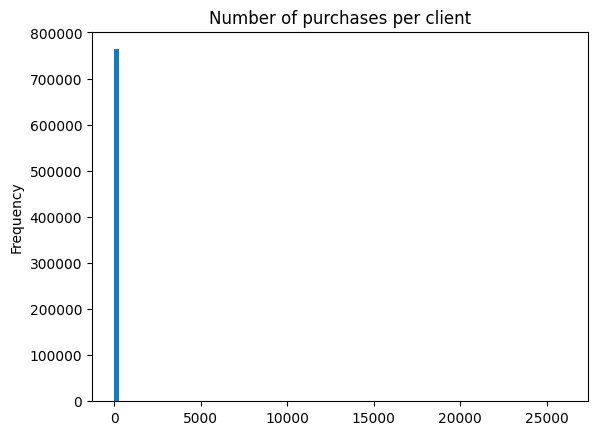

In [6]:
clients.purchases.plot(kind="hist", bins=100, title="Number of purchases per client");

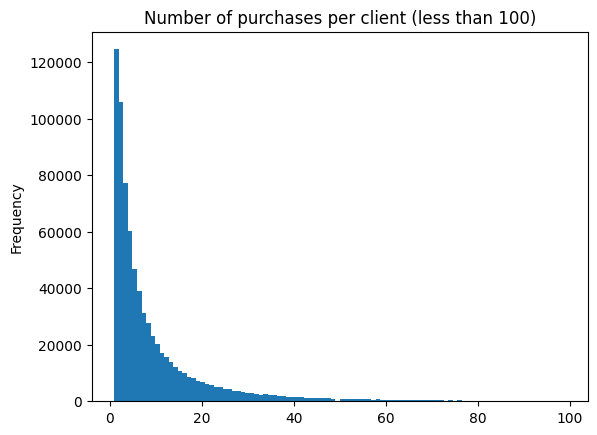

In [7]:
clients[clients.purchases < 100].purchases.plot(kind="hist", bins=100, title="Number of purchases per client (less than 100)");

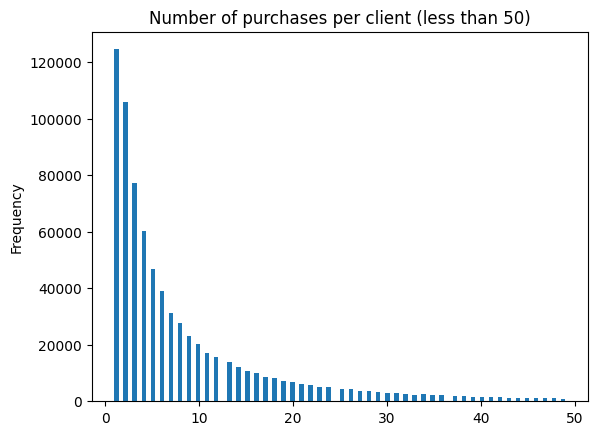

In [8]:
clients[clients.purchases < 50].purchases.plot(kind="hist", bins=100, title="Number of purchases per client (less than 50)");

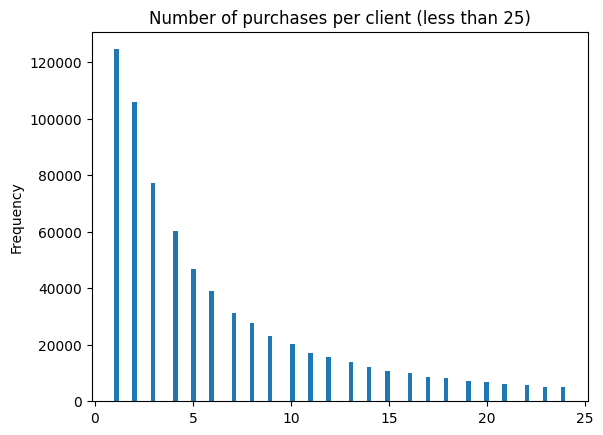

In [9]:
clients[clients.purchases < 25].purchases.plot(kind="hist", bins=100, title="Number of purchases per client (less than 25)");

In [10]:
clients[clients.purchases == 1].shape[0]

124605

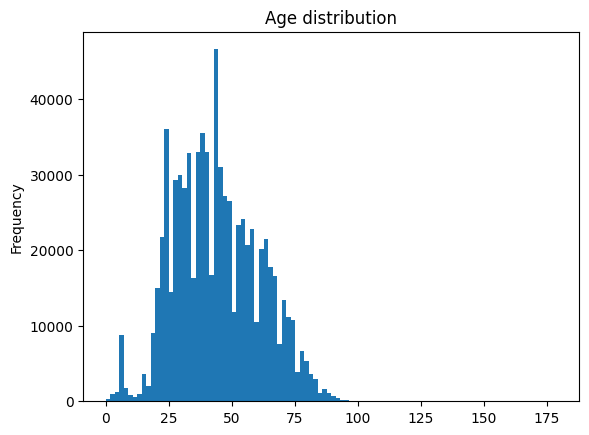

In [11]:
clients.age.plot(kind="hist", bins=100, title="Age distribution");

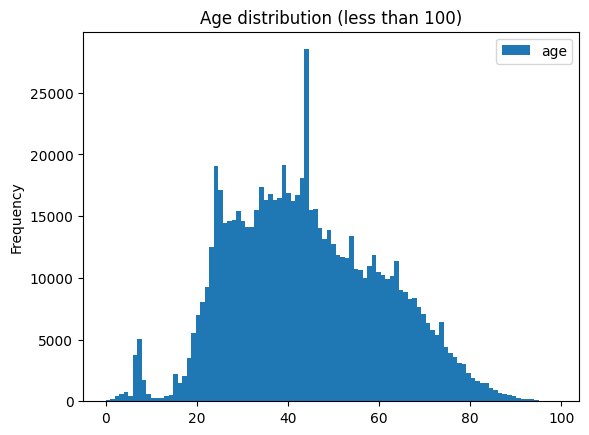

In [12]:
clients[clients.age<100].plot(kind="hist", y="age", bins=100, title="Age distribution (less than 100)");

In [13]:
clients[clients.age>100]["birth_date"].sort_values()

627817   1845-05-15
692198   1848-01-01
326475   1852-05-19
110075   1857-06-22
162734   1870-05-16
698812   1887-08-07
705490   1888-01-01
180915   1888-12-10
676717   1889-01-01
679939   1889-01-01
306105   1891-05-14
655041   1898-01-01
681835   1898-01-01
209018   1899-01-01
213151   1899-03-21
659823   1899-05-12
254760   1899-12-12
114292   1900-01-01
625460   1900-01-01
100809   1900-01-01
752042   1900-05-17
754734   1900-07-10
43237    1900-07-22
117820   1900-07-26
219777   1900-08-07
519344   1900-08-08
560683   1900-10-06
654871   1900-10-10
682375   1900-11-11
698677   1900-11-11
683324   1900-11-11
561539   1900-11-23
209572   1900-12-08
607558   1900-12-11
750360   1900-12-12
106461   1900-12-19
326593   1900-12-25
39190    1900-12-26
292959   1900-12-29
661080   1900-12-30
288248   1901-01-01
185475   1901-02-01
547995   1901-03-26
640557   1901-07-14
640901   1901-07-27
533683   1901-11-19
183250   1901-12-01
664587   1901-12-12
682942   1901-12-30
698844   1902-01-15


In [14]:
clients.total_gross_mean.mean()

np.float64(41.10369164660087)

In [15]:
clients[clients.age<100].total_gross_mean.mean()

np.float64(41.10030647869614)

In [16]:
clients[clients.age>100].total_gross_mean.mean()

np.float64(48.593911716767984)

In [17]:
clients[clients.age<100].purchases.mean()

np.float64(10.628359355673847)

In [18]:
clients[clients.age>100].purchases.mean()

np.float64(10.138392857142858)

In [19]:
clients.head()

,client_id,gender,birth_date,total_gross_sum,total_gross_mean,total_gross_max,total_gross_min,total_discount_sum,total_discount_mean,total_discount_max,total_discount_min,total_spent_sum,total_spent_mean,total_spent_max,total_spent_min,purchases,age
0,120.0,F,1977-06-08,25.99,12.995000,16.99,9.00,0.00,0.000000,0.00,0.0,25.99,12.995000,16.99,9.00,2,47.0
1,250.0,F,1974-03-29,1353.92,61.541818,261.23,7.99,552.09,25.095000,161.34,0.0,801.83,36.446818,109.90,5.99,22,50.0
2,253.0,F,1994-06-11,139.17,27.834000,42.63,7.99,25.66,5.132000,10.18,0.0,113.51,22.702000,36.24,5.49,5,30.0
3,408.0,M,1990-08-10,270.19,38.598571,79.80,15.25,99.11,14.158571,39.89,0.0,171.08,24.440000,79.79,0.01,7,34.0
4,460.0,M,1968-07-24,50.19,16.730000,33.21,5.99,0.00,0.000000,0.00,0.0,50.19,16.730000,33.21,5.99,3,56.0


In [20]:
print(f"Average gross spent per client: {clients.total_gross_sum.mean()}")
print(f"Median gross spent per client: {clients.total_gross_sum.median()}")
print(f"Average mean gross spent per client: {clients.total_gross_mean.mean()}")
print(f"Median mean gross spent per client: {clients.total_gross_mean.median()}")
print(f"Average discount gained per client: {clients.total_discount_sum.mean()}")
print(f"Median discount gained per client: {clients.total_discount_sum.median()}")

Average gross spent per client: 389.84748256817346
Median gross spent per client: 137.84
Average mean gross spent per client: 41.10369164660087
Median mean gross spent per client: 25.286
Average discount gained per client: 81.89242234675758
Median discount gained per client: 16.89


In [21]:
clients.gender.value_counts()

gender
M    400430
F    363833
Name: count, dtype: int64

In [22]:
clients.to_parquet("../data/cleaned/customers.parquet", index=False)

In [23]:
clients[clients.client_id == 55750557.0]

,client_id,gender,birth_date,total_gross_sum,total_gross_mean,total_gross_max,total_gross_min,total_discount_sum,total_discount_mean,total_discount_max,total_discount_min,total_spent_sum,total_spent_mean,total_spent_max,total_spent_min,purchases,age
536006,55750557.0,F,1980-11-18,31379.52,115.791587,1275.44,1.99,7615.9,28.102952,350.91,0.0,23763.62,87.688635,1063.0,0.01,271,43.0
